First, we'll look at how to train a linear regression model.

In [1]:
# Let's produce a randomly generated linear dataset

import numpy as np

# Generate 100 x values from 0 to 2
X = 2 * np.random.rand(100, 1)
# Generate 100 y values around the line 4 + 3*x, with some normally distributed noise
y = 4 + 3 * X + np.random.randn(100, 1)

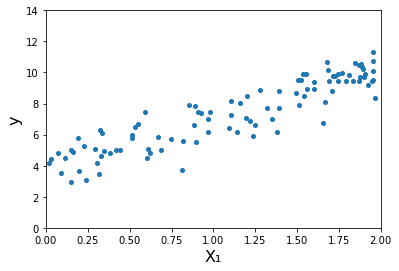

In [2]:
# Let's plot the data

import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("X\N{SUBSCRIPT ONE}", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.scatter(X, y, s=16)
plt.axis([0,2,0,14])
plt.show()

For linear regression models, we typically use an MSE(Mean Squared Error) cost function, which we want to minimize. 

There is a closed-form solution for the vector theta that does so, where y_pred = theta_0 + theta_1*x is our estimate for the line.

The formula is:

theta = (X^T*X)^(-1) * X^T * y, 

where y is the vector containing all y values in our training set, and where X = (x_1, ..., x_n) contains row vectors x_i^T = (1, x).

In [3]:
# We glue a row of ones to the top of our X matrix, before computing the cost-minimizing vector theta

X_b = np.c_[np.ones((100, 1)), X]

theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

theta_best

array([[3.79713235],
       [3.19844936]])

Our model predicts the line 4 + 2.98*x, which is... shockingly close to the values we would have hoped for.

In [4]:
# Now, given the x value of a new data point, we can make a prediction for the corresponding y-value, using our model

X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.79713235],
       [10.19403106]])

Our model predicts the points (0, 4) and (2, 9.95).

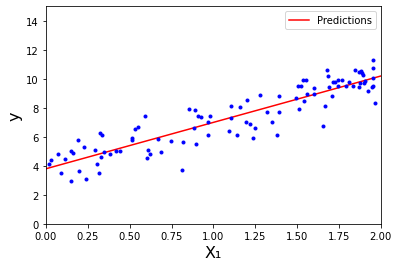

In [5]:
# We can add the model's predictions to our previous plot

pred, = plt.plot(X_new, y_predict, "r-")
pred.set_label("Predictions")
plt.legend()
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.xlabel("X\N{SUBSCRIPT ONE}", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

So we now know how to train a linear regression model "manually". Performing it using Scikit-Learn is simpler:

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
print("\N{Greek Small Letter Theta}\N{SUBSCRIPT ZERO}, \N{Greek Small Letter Theta}\N{SUBSCRIPT ONE} =", lin_reg.intercept_, lin_reg.coef_)
print("y predictions:")
lin_reg.predict(X_new)

θ₀, θ₁ = [3.79713235] [[3.19844936]]
y predictions:


array([[ 3.79713235],
       [10.19403106]])

The Linear Regression class is based on the scipy.linalg.lstsq() ("least squares") function. 

lstsq(A, b) computes the vector x which minimizes the squared Euclidean distance between A*x and b and returns it, together with the sums of residuals for each column (useful for figuring out if a linear model is appropriate), the rank & "singular values" of A.

We can also call it directly if we're feeling pretty low-level:

In [7]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
print("Model:")
print(theta_best_svd, "\n")
print("Residuals:")
print(residuals, "\n")
print("Rank:")
print(rank, "\n")
print("Singular values:")
print(s, "\n")

Model:
[[3.79713235]
 [3.19844936]] 

Residuals:
[80.97889399] 

Rank:
2 

Singular values:
[15.74681509  3.94920536] 



The function computes $\hat{\theta}=X^+y$, where $X^+$ is the *pseudoinverse* (or more precisely, the Moore-Penrose inverse) of X...

which we can also compute directly by using np.linalg.pinv() if we are feeling even more low-level:

In [8]:
np.linalg.pinv(X_b).dot(y)

array([[3.79713235],
       [3.19844936]])

Indeed, we can get EVEN DEEPER by using Singular Value Decomposition (see np.linalg.svd()) to find the pseudoinverse, but that is a topic for another day. 

A more pressing thing to think about is that the "Normal equation" method we've been looking at scales pretty poorly with the number of dimensions of our data - computing the pseudoinverse of large matrices is pretty expensive.


Instead, we can learn how to use Batch Gradient Descent to train a linear classifier - on each step of the gradient descent, we use our entire dataset to readjust our parameters.

On each step, the gradient vector of the cost function is $$\frac{2}{m}X^T(X\theta - y)$$, consisting of $$\frac{2}{m} \sum_{i=1}^m(\theta^Tx^{(i)}-y^{(i)})x_j^{(i)}$$ w. respect to each component $\theta_j$.
The gradient vector points "up-hill" on the curve of the cost function, so we just take a step in the opposite direction.

In [9]:
# This is a quick implementation of the Batch Gradient Descent algorithm

eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients # Take a step in the opposite direction of where the gradient vector points
    
theta

array([[3.79713235],
       [3.19844936]])

In [10]:
# Let's write a function that plots the predictions after each of the first steps of the process for a given learning rate eta

def plot_early_descent(eta, num_steps=10):

    plt.figure()
    plt.plot(X, y, "b.")
    plt.axis([0, 2, 0, 15])
    plt.xlabel("X\N{SUBSCRIPT ONE}", fontsize=16)
    plt.ylabel("y", fontsize=16)

    theta = np.random.randn(2,1) 
    for _ in range(num_steps):
    
        X_new = np.array([[0], [2]])
        X_new_b = np.c_[np.ones((2, 1)), X_new]
        y_predict = X_new_b.dot(theta)
        plt.plot(X_new, y_predict, "r-", alpha=0.42)
    
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients 

    plt.show()

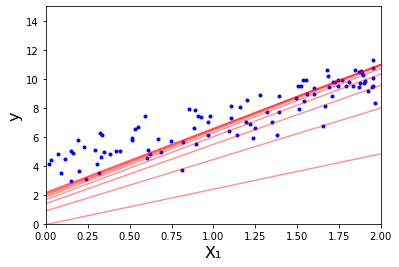

In [11]:
# With a learning rate of 0.1, our predictions should converge rapidly

plot_early_descent(0.1)

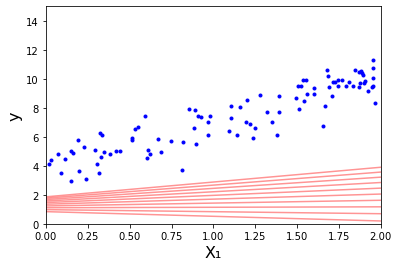

In [12]:
# But if we choose a learning rate that's too low, converging will take much longer

plot_early_descent(0.01)

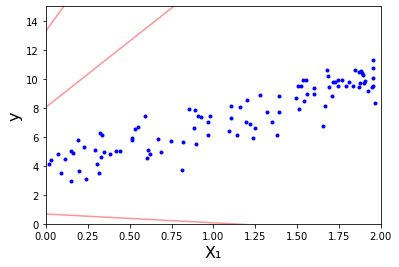

In [13]:
# If we take a learning rate that's too large on the other hand, our algorithm will jump past the optimum again and again, actually making our model continuously worse

plot_early_descent(0.5)

But with a suitable learning rate, Batch Gradient Descent will eventually take us to the optimal solution - sounds pretty good! However, since we use the entirety of the training data on each step, this method becomes very slow if our training set becomes too large. 

At the opposite extreme, Stochastic Gradient Descent picks a random instance at each step and computes the gradients based only on that single instance. Obviously, that makes the algorithm very fast! However, improvement at each step ultimately comes down to chance and our solution will never converge. This has the upside that this method has a better chance of escaping local, non-optimal minima. However, we usually want our algorithm to settle down eventually. To this end, we can implement a learning schedule that makes the learning rate decrease over time. Once the learning rate is close to 0, we have reached a stable solution - which may or may not be optimal, but which will probably be good if we choose our hyperparameters sensibly.

In [14]:
# We choose our max. number of iterations, as well as defining hyperparameters for our learning schedule and the according function, which returns the current learning rate at each step of the Stochastic Gradient Descent algorithm

n_epochs = 50  # number of steps until the algorithm stops
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

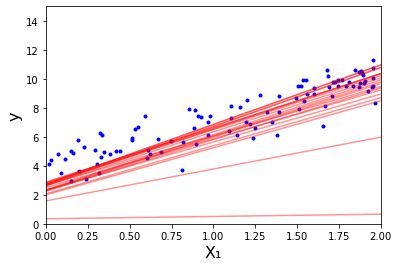

Theta:
 [[3.75195461]
 [3.2258115 ]]


In [15]:
# We then let the SGD algorithm run, plotting the model on the first 20 steps 

plt.figure()
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.xlabel("X\N{SUBSCRIPT ONE}", fontsize=16)
plt.ylabel("y", fontsize=16)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        
        if (epoch * m + i < 20):
            X_new = np.array([[0], [2]])
            X_new_b = np.c_[np.ones((2, 1)), X_new]
            y_predict = X_new_b.dot(theta)
            plt.plot(X_new, y_predict, "r-", alpha=0.42)
    
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1] # this looks weird, but we want xi to look like [[1 a]] for xi.T to look like [[1] [a]], instead of [1 a], for the formula to work
        yi = y[random_index]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        
plt.show()
print("Theta:\n", theta)

Our solution isn't quite the optimal one, but very close. We've only passed through our training set 50(=n_epochs) times, as opposed to 1000 times in our Batch Gradient Descent example.

In [16]:
# We can also just use Scikit-Learn to perform SGD for us

from sklearn.linear_model import SGDRegressor

# The following code runs for 1000 epochs or until the loss during one epoch drops by less than 0.001; it starts with a learning rate of 0.1
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
# We use the ravel() function because sgd_reg expects a 1d array, whereas our default y is a column vector.
sgd_reg.fit(X, y.ravel())

sgd_reg.intercept_, sgd_reg.coef_

(array([3.79692743]), array([3.2188333]))

Again, this is not ideal (despite passing through our training set (up to) 1000 times), but it's very close.

But what if our dataset is nonlinear? Surely, a linear won't work in that case? 


Haha, you thought! One simple way of making it work is to add powers of each feature as new features, then train a linear model on this extended set of features. This is called "Polynomial Regression".

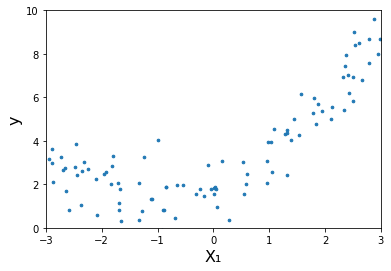

In [17]:
# We generate some nonlinear data, based on a simple quadratic equation.

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.figure()
plt.scatter(X, y, s=7)
plt.xlabel("X\N{SUBSCRIPT ONE}", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.axis([-3, 3, 0, 10])
plt.show()

A straight line will never fit this data. But we can use Scikit-Learn's PolynomialFeatures class to transform our dataset.

In [18]:
# We add the square of each feature in the training set (in this case just 1: X) as a new feature 

from sklearn.preprocessing import PolynomialFeatures 

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print("X[0]:\t\t", X[0])
print("X_poly[0]:\t", X_poly[0])

X[0]:		 [1.32407465]
X_poly[0]:	 [1.32407465 1.75317368]


X_poly now contains the original feature of X & its square. 

In [19]:
# Now we can fit a LinearRegression model to this extended training data.

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.85017434]), array([[0.99880801, 0.48909443]]))

Nice. The model estimates $\hat{y}=0.5x_1^2+x_1+1.95$, when the original function was $\hat{y}=0.5x_1^2+x_1+2$, before adding the Gaussian noise.

Note: When we have multiple features, Polynomial Regression is even capable of finding nonlinear relationships between them, since, given features a and b, PolynomialFeatures(degree=3) would not only add $a^2, a^3, b^2, b^3$, but also $ab, a^2b, ab^2$.

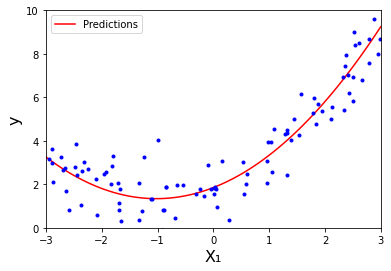

In [20]:
# Let's plot the quadratic model we were able to find via Polynomial Regression

X_coords = np.linspace(-3, 3, 100)
y_predict = lin_reg.coef_[0][1]*X_coords**2 + lin_reg.coef_[0][0]*X_coords + lin_reg.intercept_ 

pred, = plt.plot(X_coords, y_predict, "r-")
pred.set_label("Predictions")
plt.legend()
plt.plot(X, y, "b.")
plt.axis([-3, 3, 0, 10])
plt.xlabel("X\N{SUBSCRIPT ONE}", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

That does look pretty spot-on!

Attempting to find a more complex (higher-dimension) polynomial model would make us end up overfitting the data and make our model perform much worse on future testing instances. 
A linear model couldn't perform well because we would be underfitting. But how do we tell if a model is over- or underfitting?

One way is using Cross-validation. If the model does very well on the training-, but poorly on the validation set, it's overfitting. If it does poorly on both, it's underfitting. 

Another way is to look at learning curves: Something we'll explore now. 

In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    # We split our data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

    # After each step of the learning process, we measure the model's average error on the validation set & on the training set
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    
    # After the training process is done, we plot the data we have collected, enabling us to compare the progress our model made on "known" and "unknown" data
    trn, = plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    vltn, = plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    trn.set_label("train")
    vltn.set_label("val")
    plt.legend()
    plt.axis([0, 80, 0, 3])
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")

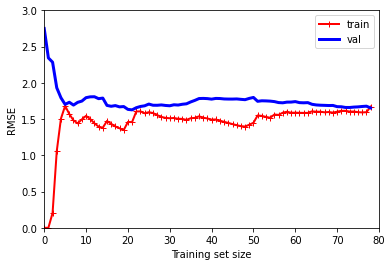

In [34]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

This model is underfitting. 
The training error curve starts at 0, since it can fit one or two instances perfectly. But since the data is noisy and not linear at all, the average error ramps up quickly until it reaches a plateau. 
As the model learns, the valuation error slowly goes down. But it also reaches a plateau, very close to the training error.

These features ar typical for a model that's underfitting: Both curves reach a plateau; they are close and fairly high. 